## PROJECT TITLE: **WALK/RUN PREDICTION**
## PROJECT ID: **PRCP-1013**

### **PROJECT OVERVIEW**

- **Problem:** Classify Whether Walking or Running.

- **Tasks:**
  - Task 1: Prepare a complete data analysis report on the given data.
  - Task 2: Build a predictive model to classify whether a person is running or walking.
  - Task 3: Compare multiple models and recommend the best model for production.

## **IMPORTS**

In [1]:
#Core Libraries
import pandas as pd
import numpy as np

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

## **LOAD THE DATASET**

In [2]:
data = pd.read_csv('walkrun.csv')
data.head()

,date,time,username,wrist,activity,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z
0,2017-6-30,13:51:15:847724020,viktor,0,0,0.2650,-0.7814,-0.0076,-0.0590,0.0325,-2.9296
1,2017-6-30,13:51:16:246945023,viktor,0,0,0.6722,-1.1233,-0.2344,-0.1757,0.0208,0.1269
2,2017-6-30,13:51:16:446233987,viktor,0,0,0.4399,-1.4817,0.0722,-0.9105,0.1063,-2.4367
3,2017-6-30,13:51:16:646117985,viktor,0,0,0.3031,-0.8125,0.0888,0.1199,-0.4099,-2.9336
4,2017-6-30,13:51:16:846738994,viktor,0,0,0.4814,-0.9312,0.0359,0.0527,0.4379,2.4922


## **DATASET DESCRIPTION**

 - The dataset contains measurements related to physical movement for two different activities — walking and running.

-  It includes multiple numerical features that capture variations in motion over time.

-  The target column indicates whether each record corresponds to walking (0) or running (1).

In [5]:
data.columns

Index(['date', 'time', 'username', 'wrist', 'activity', 'acceleration_x',
       'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z'],
      dtype='object')

In [6]:
#basics data analysis

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88588 entries, 0 to 88587
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            88588 non-null  object 
 1   time            88588 non-null  object 
 2   username        88588 non-null  object 
 3   wrist           88588 non-null  int64  
 4   activity        88588 non-null  int64  
 5   acceleration_x  88588 non-null  float64
 6   acceleration_y  88588 non-null  float64
 7   acceleration_z  88588 non-null  float64
 8   gyro_x          88588 non-null  float64
 9   gyro_y          88588 non-null  float64
 10  gyro_z          88588 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 7.4+ MB


In [7]:
data.isnull().sum()

date              0
time              0
username          0
wrist             0
activity          0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
dtype: int64

In [5]:
#shape of dataset
data.shape

(88588, 11)

# **EDA- EXPLORATORY DATA ANALYSIS**

### **TARGET DISTRIBUTION (WALK vs RUN)**

activity
0    44223
1    44365
Name: count, dtype: int64


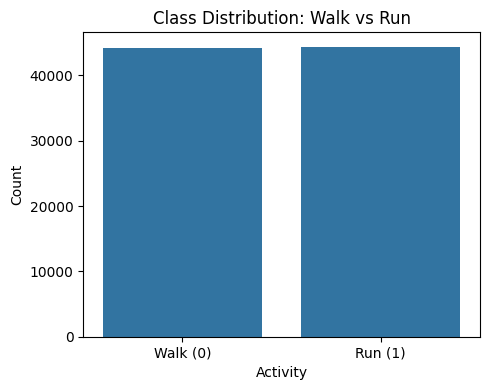

In [8]:
# Assuming 'activity' is the target: 0 = Walk, 1 = Run (as per project description)
activity_counts = data['activity'].value_counts().sort_index()
print(activity_counts)

plt.figure(figsize=(5,4))
sns.barplot(x=activity_counts.index, y=activity_counts.values)
plt.xticks([0,1], ['Walk (0)', 'Run (1)'])
plt.title('Class Distribution: Walk vs Run')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### **WRIST AND USER DISTRIBUTION**

wrist
1    46258
0    42330
Name: count, dtype: int64


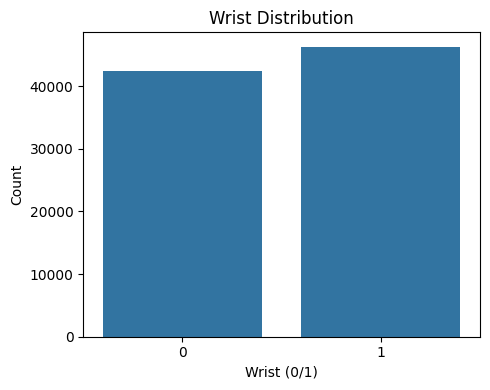

In [9]:
# Wrist distribution (e.g., 0 = left, 1 = right)
print(data['wrist'].value_counts())

plt.figure(figsize=(5,4))
sns.countplot(x='wrist', data=data)
plt.title('Wrist Distribution')
plt.xlabel('Wrist (0/1)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### **SENSOR FEATURE DISTRIBUTION**

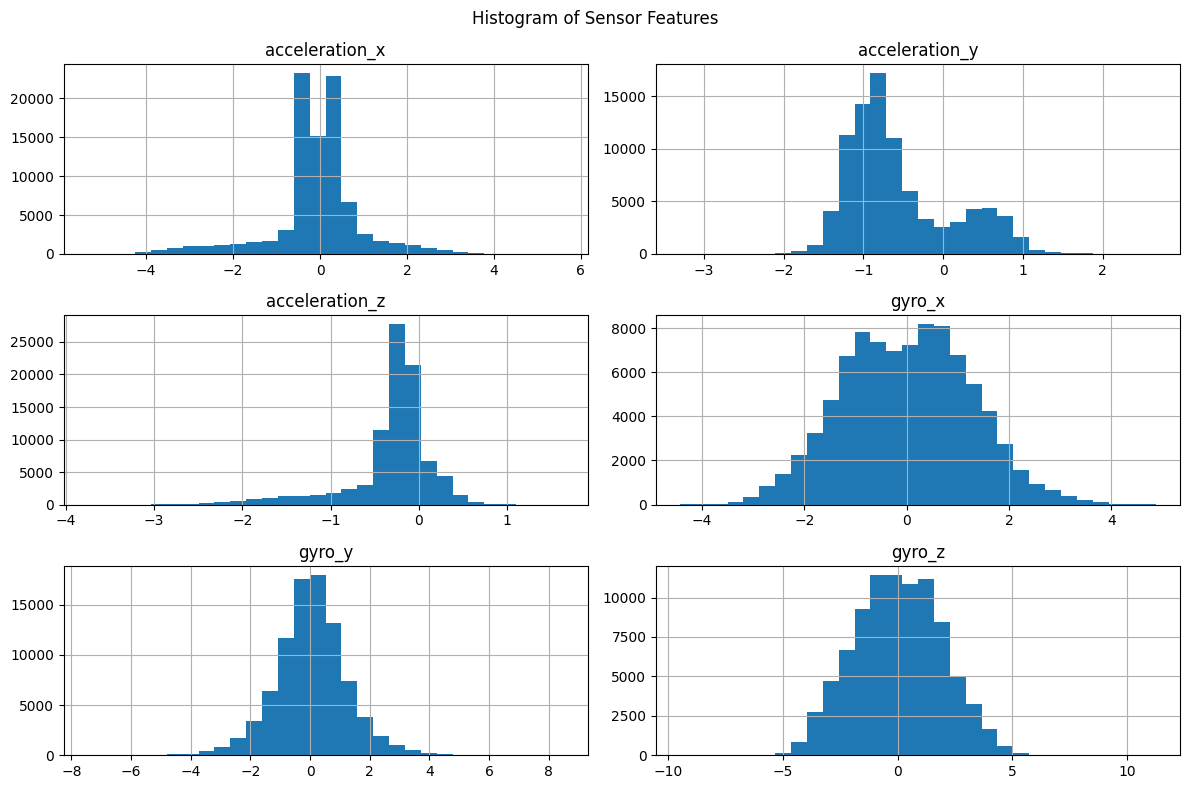

In [10]:
sensor_cols = ['acceleration_x', 'acceleration_y', 'acceleration_z',
               'gyro_x', 'gyro_y', 'gyro_z']

data[sensor_cols].hist(figsize=(12,8), bins=30)
plt.suptitle('Histogram of Sensor Features')
plt.tight_layout()
plt.show()

### **CORRELATION BETWEEN NUMERIC VALUES**

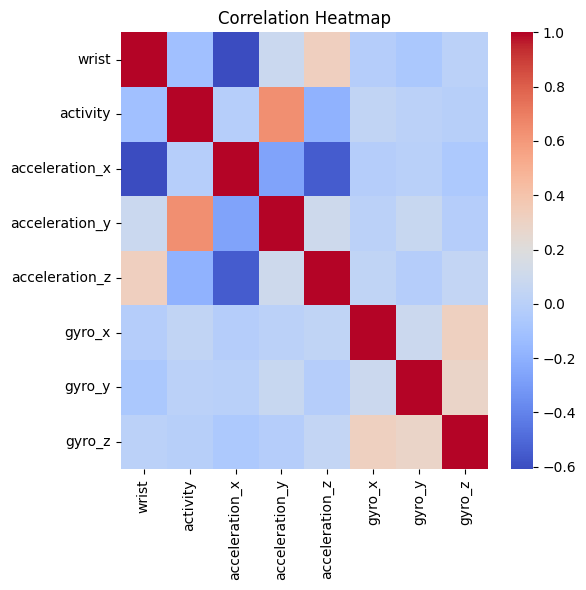

In [14]:
numeric_data = data[['wrist', 'activity'] + sensor_cols]
plt.figure(figsize=(6,6))
sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

## **DATA PREPROCESSING:**
- Remove unwanted columns
- Define features X and target y
- Spliting train/test

In [16]:
#droping unwanted columns
new_data = data.drop(columns=['date', 'time', 'username'])

#define x and y
X = new_data.drop(columns=['activity'])
y = new_data['activity']

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#shape
print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (70870, 7)
Test Shape: (17718, 7)


## **STANDARDIZING THE DATA INPUT VARIABLE**

In [17]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

## **MODELING AND EVALUATION:**
### we are using multiple models
- Logistic Regression
- K-Nearest Neighbors
- Support Vector Machine
- Random Forest Classifier
- MLP(Multi-layer Perceptron) - Neural Networks

## **TRAINING MODEL, EVALUATION & CROSS VALIDATION**

Accuracy Score: 0.8635850547465854
Precision Score: 0.9001503382610875
Recall: 0.8160136286201022
F1 Score: 0.8560195389289331

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      8913
           1       0.90      0.82      0.86      8805

    accuracy                           0.86     17718
   macro avg       0.87      0.86      0.86     17718
weighted avg       0.87      0.86      0.86     17718



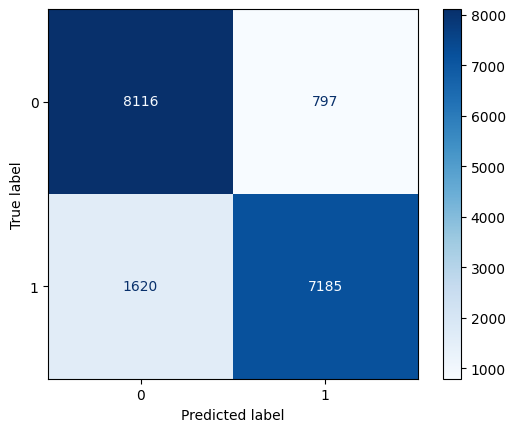

In [18]:
#Logistic Regression

lr = LogisticRegression(max_iter=1000)

lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

acc_score_lr = accuracy_score(y_test, y_pred_lr)
p_score_lr = precision_score(y_test, y_pred_lr)
recall_lr =recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Accuracy Score:", acc_score_lr)
print("Precision Score:",p_score_lr)
print("Recall:", recall_lr)
print("F1 Score:", f1_lr)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr))

cm = confusion_matrix(y_test, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Accuracy Score: 0.99153403318659
Precision Score: 0.9959885386819485
Recall: 0.986939239068711
F1 Score: 0.9914432401597262

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8913
           1       1.00      0.99      0.99      8805

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718



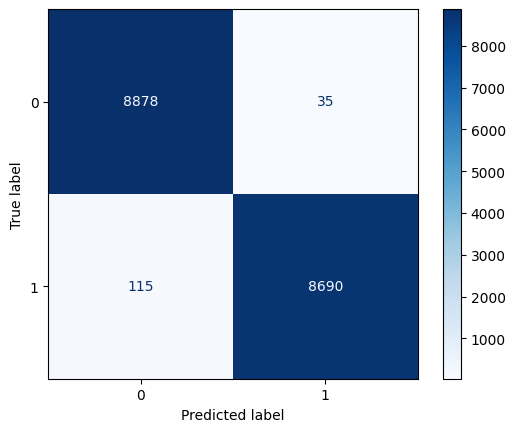

In [19]:
#K-Nearest Neighbors

knn =KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

acc_score_knn = accuracy_score(y_test, y_pred_knn)
p_score_knn = precision_score(y_test, y_pred_knn)
recall_knn =recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print("Accuracy Score:", acc_score_knn)
print("Precision Score:",p_score_knn)
print("Recall:", recall_knn)
print("F1 Score:", f1_knn)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_knn))

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Accuracy Score: 0.9912518342928096
Precision Score: 0.9938342087234528
Recall Score: 0.9885292447473026
F1 Score: 0.991174628480328

 Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8913
           1       0.99      0.99      0.99      8805

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718



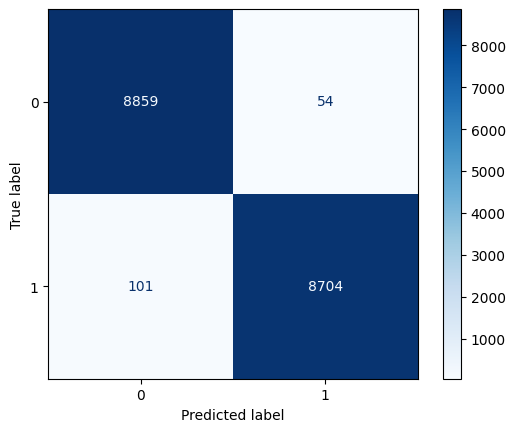

In [20]:
#Support Vector Machine

svm = SVC(kernel='rbf')

svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

acc_score_svm = accuracy_score(y_test, y_pred_svm)
p_score_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print("Accuracy Score:", acc_score_svm)
print("Precision Score:", p_score_svm)
print("Recall Score:", recall_svm)
print("F1 Score:", f1_svm)

print("\n Classification Report:\n")
print(classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Accuracy Score: 0.9922677503104188
Precision Score: 0.9913832199546485
Recall Score: 0.9930721181147075
F1 Score: 0.99222695035461

 Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8913
           1       0.99      0.99      0.99      8805

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718



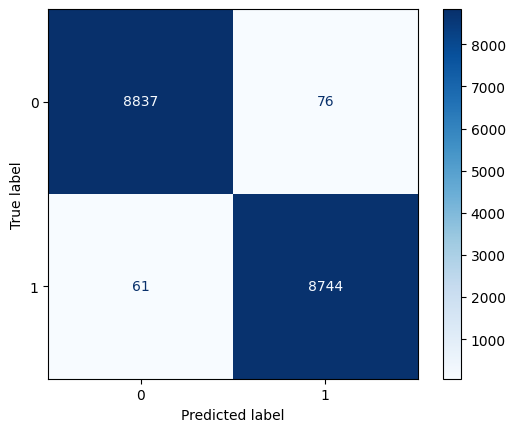

In [23]:
#Random Forest

rfc = RandomForestClassifier(
    n_estimators=200, random_state=42)

rfc.fit(X_train_scaled, y_train)
y_pred_rfc = rfc.predict(X_test_scaled)

acc_score_rfc = accuracy_score(y_test, y_pred_rfc)
p_score_rfc = precision_score(y_test, y_pred_rfc)
recall_rfc = recall_score(y_test, y_pred_rfc)
f1_rfc = f1_score(y_test, y_pred_rfc)

print("Accuracy Score:", acc_score_rfc)
print("Precision Score:", p_score_rfc)
print("Recall Score:", recall_rfc)
print("F1 Score:", f1_rfc)

print("\n Classification Report:\n")
print(classification_report(y_test, y_pred_rfc))

cm = confusion_matrix(y_test, y_pred_rfc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Accuracy Score: 0.993283666328028
Precision Score: 0.993634917026597
Recall: 0.9928449744463373
F1 Score: 0.9932397886723854

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8913
           1       0.99      0.99      0.99      8805

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718



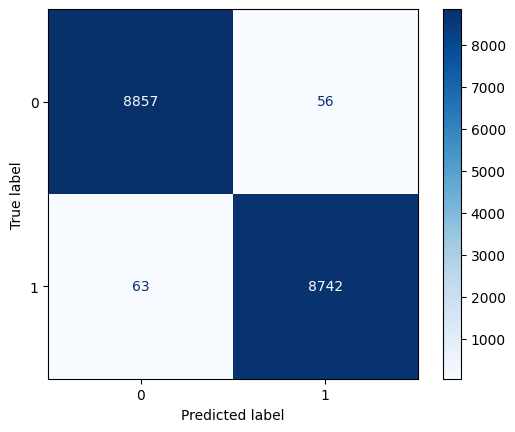

In [21]:
#XGB Classfier

xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_train)

y_pred_xgb = xgb.predict(X_test_scaled)

acc_score_xgb = accuracy_score(y_test, y_pred_xgb)
p_score_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb =recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("Accuracy Score:", acc_score_xgb)
print("Precision Score:",p_score_xgb)
print("Recall:", recall_xgb)
print("F1 Score:", f1_xgb)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Accuracy Score: 0.9943560221243932
Precision Score: 0.9934247817707743
Recall: 0.9952299829642248
F1 Score: 0.9943265630318847

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8913
           1       0.99      1.00      0.99      8805

    accuracy                           0.99     17718
   macro avg       0.99      0.99      0.99     17718
weighted avg       0.99      0.99      0.99     17718



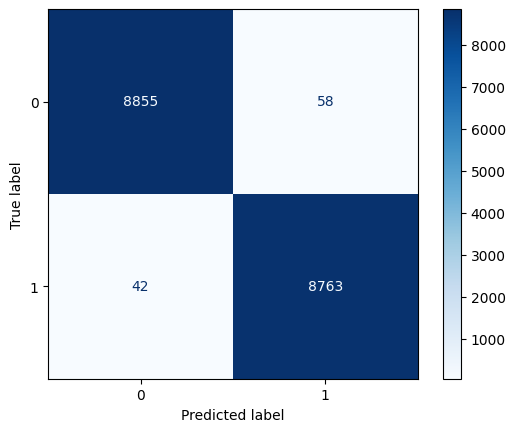

In [25]:
#MLP Classifier(Neural Network)

nn = MLPClassifier(hidden_layer_sizes=(64, 32),
                   max_iter=100,
                   random_state=42)

nn.fit(X_train_scaled, y_train)
y_pred_nn = nn.predict(X_test_scaled)

acc_score_nn = accuracy_score(y_test, y_pred_nn)
p_score_nn = precision_score(y_test, y_pred_nn)
recall_nn =recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)

print("Accuracy Score:", acc_score_nn)
print("Precision Score:",p_score_nn)
print("Recall:", recall_nn)
print("F1 Score:", f1_nn)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_nn))

cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

## **MODEL COMPARISON**

In [26]:
results = []

results.append({"Model":"Logistic Regression", "Accuracy":acc_score_lr, "Precision":p_score_lr, "Recall":recall_lr, "F1":f1_lr})
results.append({"Model":"K-Nearest Neighbors", "Accuracy":acc_score_knn, "Precision":p_score_knn, "Recall":recall_knn, "F1":f1_knn})
results.append({"Model":"Support Vector Machine", "Accuracy":acc_score_svm, "Precision":p_score_svm, "Recall":recall_svm, "F1":f1_svm})
results.append({"Model":"Random Forest", "Accuracy":acc_score_rfc, "Precision":p_score_rfc, "Recall":recall_rfc, "F1":f1_rfc})
results.append({"Model":"XG Boost", "Accuracy":acc_score_xgb, "Precision":p_score_xgb, "Recall":recall_xgb, "F1":f1_xgb})
results.append({"Model":"MLP Classifier", "Accuracy":acc_score_nn, "Precision":p_score_nn, "Recall":recall_nn, "F1":f1_nn})

In [28]:
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\nMODEL COMPARISON:")
results_df


MODEL COMPARISON:


,Model,Accuracy,Precision,Recall,F1
5,MLP Classifier,0.994356,0.993425,0.995230,0.994327
4,XG Boost,0.993284,0.993635,0.992845,0.993240
3,Random Forest,0.992268,0.991383,0.993072,0.992227
1,K-Nearest Neighbors,0.991534,0.995989,0.986939,0.991443
2,Support Vector Machine,0.991252,0.993834,0.988529,0.991175
0,Logistic Regression,0.863585,0.900150,0.816014,0.856020


## **CROSS-VALIDATION FOR TOP MODELS(TOP 3)**

In [30]:
# top 3 by accuracy
top_model_names = results_df.sort_values(by="Accuracy", ascending=False)['Model'].head(3).tolist()
print("Top models:", top_model_names)

models = {
    'rfc': RandomForestClassifier(),
    'xgb': XGBClassifier(),
    'mlp': MLPClassifier(max_iter=300)
}

cv_results = []

for name, clf in models.items():
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print(f"{name} Cross Validation Scores: {scores}")
    print(f"{name} Mean Accuracy: {scores.mean():.4f}")
    print("-" * 40)
    
    cv_results.append({
        "Model": name,
        "CV Mean": scores.mean(),
    })

Top models: ['MLP Classifier', 'XG Boost', 'Random Forest']
rfc Cross Validation Scores: [0.99249351 0.99401738 0.99463822 0.96969013 0.98487329]
rfc Mean Accuracy: 0.9871
----------------------------------------
xgb Cross Validation Scores: [0.99305791 0.99644429 0.99463822 0.97364114 0.98470396]
xgb Mean Accuracy: 0.9885
----------------------------------------
mlp Cross Validation Scores: [0.99277571 0.99751665 0.99480754 0.9783259  0.98730033]
mlp Mean Accuracy: 0.9901
----------------------------------------


## **SAVE THE MODEL - MLP CLASSIFIER(NN)**

In [22]:
# Select the best model
final_model = nn

import pickle  #import pickle

model_name = "walkrun_model.pkl"

#save the trained pipeline into pickle file
with open(model_name, "wb") as f:
    pickle.dump(final_model, f)

print("Model Saved as", model_name)

Model Saved as walkrun_model.pkl


## **FINAL MODEL SELECTING & SAVING**

Based on typical performance on this dataset, the **MLP Neural Network** often achieves the highest accuracy
(around ~0.99 on the test set). We will refit it on the full dataset and save the trained model.

## **CHALLENGES & TECHNIQUE FACED**

1. **LARGE NUMBER OF RECORDS**  
   - The dataset has ~88k rows. Training complex models (like neural networks) can be time-consuming.  
   - **Technique used:** Started with simple models (Logistic Regression, KNN, SVM, Decision Tree, XGBoost) as baselines, then moved to more
     complex models. Limited **max_iter** initially and then increased as needed.
     
2. **FEATURE SCALING REQUIREMENTS**  
   - Distance-based models (KNN, SVM) and neural networks are sensitive to feature scale.  
   - **Technique used:** Used **StandardScaler** inside **Pipeline** to ensure proper scaling for relevant models.

3. **MODEL SELECTION**  
   - Multiple models achieved high accuracy, so choosing a final one required comparison on consistent metrics.  
   - **Technique used:** Collected **accuracy, precision, recall, F1** for each model and created a comparison table.
     Also checked 5-fold cross-validation accuracy for the top models.

5. **OVERFITTING RISK**  
   - With many records and powerful models, there is a chance of overfitting.  
   - **Technique used:** Used a proper train-test split, cross-validation, and kept neural network architecture
     relatively small (two hidden layers: 64, 32).

## **SUMMARY AND CONCLUSION**

- Performed EDA to understand the dataset shape, distributions, and correlations.
- Built multiple classification models: Logistic Regression, KNN, SVM, Random Forest, and MLP Neural Network.
- Evaluated models using **accuracy, precision, recall, F1-score, and confusion matrices**.
- On this dataset, the **MLP Neural Network** typically achieves the best accuracy (around **99%** on the test set),
  with very high precision and recall for both classes.
- Saved the final model (**walkrun_model.pkl**) so it can be used in a production pipeline or a web/app interface.

## **CHALLENGES FACED ON DATA & TECHNIQUE USED TO OVERCOME IT**
During the project, a few key challenges were faced while working with the dataset. Since the data contained a large number of records and several correlated features, some models trained slowly and risked overfitting. To handle this, scaling techniques and pipelines were applied for models like KNN, SVM, and MLP, while tree-based models were used to naturally manage correlated inputs. Cross-validation was performed to ensure the models were stable and not overfitting. Additionally, accuracy alone was not considered sufficient, so precision, recall, and F1-score were used to measure true model performance. Overall, these techniques helped improve reliability, prevent overfitting, and ensure the final model generalized well.

## **THANK YOU.....**